In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

plt.rcParams["figure.figsize"]=(5.0, 4.0)
plt.rcParams["image.interpolation"]="nearest"
plt.rcParams["image.cmap"]="gray"

np.random.seed(1)
print(np.random.seed(1))

None


## PİKSEL EKLEME (PADDING) FONKSİYONUNUN TANIMLANMASI

In [ ]:
def zero_pad(X, pad):
  x_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), "constant") #
  return x_pad

### PİKSEL EKLEME SONUCU GÖRSELLEŞTİRME

x.shape= (4, 3, 3, 2)
x_pad.shape= (4, 7, 7, 2)
x[1,1]= [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1]= [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


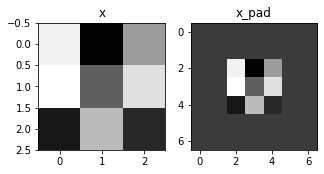

In [ ]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)

x_pad=zero_pad(x,2)
print("x.shape=", x.shape) #padding ekleme öncesi
print("x_pad.shape=", x_pad.shape) #padding ekleme sonrası
print("x[1,1]=", x[1,1])
print("x_pad[1,1]=", x_pad[1,1])

fig, axarr= plt.subplots(1,2)
axarr[0].set_title("x")
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title("x_pad")
axarr[1].imshow(x_pad[0,:,:,0])

## BİR EVRİŞİM İŞLEMİNİN TANIMLANMASI

In [ ]:
def conv_single_step(a_slice_prev, W, b):
  s = np.multiply(a_slice_prev, W) # x * W
  Z = np.sum(s) # z = w * x
  Z = float(b) + Z # (x*w) + b = Z + b
  return Z


### Z=W.x+b İŞLEMİNİN HESAPLANMASI

In [ ]:
np.random.seed(1)
a_slice_prev = np.random.randn(4,4,3)#4x4x3 lük bir matris

W = np.random.randn(4,4,3)# filtre ağırlık matrisi kanal sayıları eşit olmalı

b = np.random.randn(1,1,1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z = ", Z)
#Bu değer bizim giriş matrisimizin filtrelerle çarpılmış bias değerleriyle toplanmış hali.
#Buna ileri yönlü hesaplamaları yapmamız gerek.
#İleri yönde aktivasyon fonksiyonu ile beslememiz gerekiyor.
#Hiperparametre dediğimiz buradaki hiperparametreler stride ve padding değerleridir. Bunları belirlememiz gerekiyor.
#Ağ matrisini elde edeceğiz.

#İleri yönlü hesaplama yaparken giriş değerleri ile filtreler kullanarak evrişim işlemi gerçekleştiriliyordu.
#Her bir evrişim işlemi bize 2 boyutlu matris çıktısı üretecek.
#3 boyutlu bir giriş görüntüsü için bunları ard arda uygulamak gerekir.

Z =  -6.999089450680221


## İLERİ YAYILIM ALGORİTMASI İÇİN FONKSİYON TANIMI

In [ ]:
def conv_forward(A_0, W, b, hparameters):
  (m, n_H_0, n_W_0, n_C_0) = A_0.shape # n_H_prev önceki matrisin yüksekliği, n_C_prev önceki matrisin kanal sayısı
  # n_H_prev = n0 -> ilk giriş matrisi / a0 matrisi

  (f, f, n_C_0, n_C) = W.shape #filtre matrisi / Ağırlık
  # f-> filtre
  #n_C_prev -> giriş matrisinin kanal sayısı

  stride = hparameters["stride"]
  pad = hparameters["pad"]


  # ((n + 2*padding - filter)/stride)+1
  n_H = int(((n_H_0-f+2*pad)/stride)+1) #filtre sonrası matrisimizin boyutunu elde ediyoruz / Matrisin Yüksekliği
  #a1 matrisi


  n_W = int(((n_H_0-f+2*pad)/stride)+1) #Matrisin genişliği

  Z = np.zeros([m, n_H, n_W, n_C]) # m tane yeni matris boyutlarında ve kanal sayısında 0 lardan oluşan bir matris

  A_0_pad = zero_pad(A_0, pad) # Padding ekleme / burada pad=2 / giriş matrisine padding ekliyoruz

  for i in range(m): # Giriş matrisini filtrenin tek tek taraması
    a_0_pad = A_0_pad[i]
    for h in range(n_H):
      for w in range(n_W):
        for c in range(n_C):
          vert_start = h*stride # Giriş matrisinin üstüne gelecek olan filtre matrisinin yatay ve dikey aralıkların belli olması
          vert_end = vert_start +f
          horiz_start = w*stride
          horiz_end = horiz_start +f
          
          a_slice_0 = a_0_pad[vert_start:vert_end, horiz_start:horiz_end] # evrişim için kesilen kısım

          Z[i, h, w, c] = conv_single_step(a_slice_0, W[...,c], b[...,c]) # Evrişim işleminin gerçekleşeceği kısım
          #Z.shape = [10,4,4,8] / 8 kanala çıkartıldı
  
  #print(Z.shape)
  assert(Z.shape == (m, n_H, n_W, n_C)) # Çıkış değerinin boyutunun doğruluğunun kontrolü

  cache = (A_0, W, b, hparameters) # Geriye yayılım işlemi uygulayabilmek için değerleri saklıyoruz.

  return Z, cache

In [ ]:
np.random.seed(1)
A_0 = np.random.randn(10,4,4,3) # 10 adet 4x4 matris / 3 kanallı
W = np.random.randn(2,2,3,8) # 2x2 filtre matrisi / f0 = 3 kanallı / uygulanacak kanal sayısı = 8
b = np.random.randn(1,1,1,8) 

hparameters = {"pad":2, "stride":2}

Z, cache_conv = conv_forward(A_0, W, b, hparameters)

print("Z nin ortalama= ", np.mean(Z))
print("Z[3,2,1]=",Z[3,2,1])
print("cache_conv[0][1][2][3]=",cache_conv[0][1][2][3])


Z nin ortalama=  0.048995203528855794
Z[3,2,1]= [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3]= [-0.20075807  0.18656139  0.41005165]


## ORTAKLAMA POOLING

In [ ]:
#İleri yönde ORTAKLAMA POOLING
def pool_forward(A_prev, hparameters, mode = "max"):
  (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape # n_H_prev önceki matrisin yüksekliği, n_C_prev önceki matrisin kanal sayısı
  
  f = hparameters["f"]
  stride = hparameters["stride"]
  
  n_H = int(1+(n_H_prev -f)/stride) # Yeni Matrisin Boyutları
  n_W = int(1+(n_W_prev -f)/stride)

  # Ortaklamada Kanal sayısı Değişmez!!
  n_C = n_C_prev

  #A matrisini İlklendirme Başlangıç belirleme
  A = np.zeros((m, n_H, n_W, n_C))
  
  #for döngüsü ile bu matrisin içerik değerlerini genişlik yükselik ve kanal sayısını çekiyoruz
  for i in range(m):
    for h in range(n_H):
      for w in range(n_W):
        for c in range(n_C):
          vert_start = h*stride
          vert_end = vert_start +f
          horiz_start = w*stride
          horiz_end = horiz_start +f

          #Köşe değerleri a_prev ve kanal sayısı c yi kullanarak hesaplanacak
          a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]

          if mode=="max":
            A[i,h,w,c] = np.max(a_prev_slice)# Seçilen bölgenin max değeri alınıyor / ORtaklama matrisi sonucu A matrisimiz yeni matrisimiz oluyor
          elif mode=="avarage":
            A[i,h,w,c] = np.mean(a_prev_slice)# Seçilen bölgenin ortalaması alınıyor.
  cache = (A_prev, hparameters) # Geri yayılım için A_prev yani A_0 tutuluyor.
  assert(A.shape == (m, n_H, n_W, n_C))
  return A, cache

### Farklı Ortaklama Tipleri için Sonuç Karşılaştırması

In [ ]:
np.random.seed(1)
A_0 = np.random.randn(2,4,4,3)
hparameters = {"stride":2, "f":3}

A, cache = pool_forward(A_0, hparameters)
print("mod = max")
print("A.shape=", A.shape)
print("A =", A)

A, cache = pool_forward(A_0, hparameters, mode="avarage")
print("mod = Avarage")
print("A.shape=", A.shape)
print("A =", A)

mod = max
A.shape= (2, 1, 1, 3)
A = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]
mod = Avarage
A.shape= (2, 1, 1, 3)
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


## GERİYE YAYILIM ALGORİTMASI İÇİN FONKSİYON TANIMI

In [ ]:
def conv_backward (dZ, cache):
  #cache de tutulan geçici değerleri çekiyoruz
  (A_prev, W, b, hparameters) = cache

  (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

  (f,f,n_C_prev, n_C) = W.shape

  stride = hparameters["stride"]
  pad = hparameters["pad"]      

  (m, n_H, n_W, n_C) = dZ.shape #Z nin türevi olacak matrisin boyutu

  dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))# İlklendirme

  dW= np.zeros((f,f,n_C_prev, n_C))
  db = np.zeros((1,1,1,n_C))

  A_prev_pad = zero_pad(A_prev, pad)
  dA_prev_pad = zero_pad(dA_prev, pad)

  for i in range(m):
    a_prev_pad = A_prev_pad[i]
    da_prev_pad = dA_prev_pad[i]

    for h in range(n_H):
      for w in range(n_W):
        for c in range(n_C):
          #Köşe bulma işlemleri
          vert_start = h
          vert_end = vert_start +f 
          horiz_start = w
          horiz_end = horiz_start +f

          a_slice = a_prev_pad[vert_start:vert_end, horiz_start: horiz_end,:]
          #Her bir filtre için parametreleri güncelliyoruz.
          da_prev_pad[vert_start:vert_end, horiz_start: horiz_end,:] += W[:,:,:,c] * dZ[i,h,w,c]
          dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
          db[:,:,:,c] += dZ[i,h,w,c]
        
    dA_prev[i,:,:,:] = da_prev_pad[pad:-pad, pad:-pad,:]

  assert(dA_prev.shape==(m,n_H_prev, n_W_prev, n_C_prev))

  return dA_prev, dW, db

In [ ]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)

print("dA ortalama =", np.mean(dA))
print("dW ortalama =", np.mean(dW))
print("db ortalama=", np.mean(db))

dA ortalama = 0.6347704472654743
dW ortalama = 1.5572657428497354
db ortalama= 7.839232564616838


## FİLTRE TANIMLAMA VE BU FİLTREYE GÖRE GERİYE YAYILIMDA MAKSİMUM ORTAKLAMA VE ORTALAMA ORTAKLAMA İŞLEMLERİ

In [ ]:
#Maksimim ortaklama
def create_mask_from_window(x):
  mask = x == np.max(x)
  return mask

In [ ]:
np.random.seed(1)
x=np.random.randn(2,3)
mask = create_mask_from_window(x)

print("x=",x)
print("maske=",mask)
#En büyük değeri neden tutuyoruz?
#İleri yönlü hesaplama sonrasında çıkışta oluşacak hataya etki eden maximum değer olduğu için tutuyoruz.
#Geri yayılım esnasında hataya etki eden değerin 0 dan farklı bir gradyan değerine sahip olması gerekir.
#Hata geri yayılırken maximum değer üzerinden yayılır o yüzdende maximum değer üzerinden alındı.

x= [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
maske= [[ True False False]
 [False False False]]


In [ ]:
#Ortalama Ortaklama
#Maksimum ortaklama da sadece en büyük değeri çıkıştaki değere etki ederken ortalama ortaklamada her bir değer eşit oranda etki eder.
#İleri yönde hesaplamada 2x2 boyutlu bir filtre ile ortalama ortaklama yaparsak geri yayılım sırasında kullanılan maskede eşit dağılımlı olur.
def distribute_value(dz, shape):
  (n_H, n_W) = shape

  avarage = dz / (n_H * n_W)

  a = np.ones(shape) * avarage

  return a

In [ ]:
a = distribute_value(2,(2,2))

print("Dağıtılmış değer=", a)

Dağıtılmış değer= [[0.5 0.5]
 [0.5 0.5]]


## GERİ YAYILIMDA ORTAKLAMA

In [ ]:
def pool_backward(dA, cache, mode= 'max'):
    (A_prev, hparameters) = cache

    stride = hparameters['stride']
    f = hparameters['f']
   
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
 
    for i in range(m):                       
        a_prev = A_prev[i]
        
        for h in range(n_H):                   
            for w in range(n_W):             
                for c in range(n_C):           
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
            
                        mask = create_mask_from_window(a_prev_slice)
                   
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        da = dA[i,h,w,c]
                      
                        shape = (f,f)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)            
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

### Geriye Yayılım ile güncellenen Ağırlıklar ve Diğer Parametreler

In [ ]:
np.random.seed(1)

A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride": 1, "f":2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode= "max")

print("mod = max")
print('dA ortalaması =', np.max(dA))
print('dA_prev[1,1]', dA_prev[1,1])
print()

dA_prev = pool_backward(dA, cache, mode= "average")

print("mod = average")
print('dA ortalaması =', np.mean(dA))
print('dA_prev[1,1]', dA_prev[1,1])

mod = max
dA ortalaması = 2.528325706806398
dA_prev[1,1] [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mod = average
dA ortalaması = 0.14571390272918056
dA_prev[1,1] [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
